# Sistema de detección de minas utilizando GPR y CNN

## Importaciones

In [ ]:
!pip install tensorflow-addons[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import joblib
import h5py
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import ndimage
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, callbacks, utils
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.2


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 21 18:00:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Funciones

### Lectura de C-scans

In [ ]:
def read_c_scan(filename: str, polarization: str):
    data_frame = h5py.File(filename, 'r')

    t0 = data_frame['Time'].attrs['t0']
    tf = data_frame['Time'].attrs['tf']
    qt = int(data_frame['Time'].attrs['q'])
    # x- and y-axis lower limits, upper limits and step are retrieved
    x0 = data_frame['Position'].attrs['x0']
    dx = data_frame['Position'].attrs['dx']
    xf = data_frame['Position'].attrs['xf']
    y0 = data_frame['Position'].attrs['y0']
    dy = data_frame['Position'].attrs['dy']
    yf = data_frame['Position'].attrs['yf']
    print(f"x: ({x0}, {xf})")
    print(f"y: ({y0}, {yf})")
    # Amount of steps over each axis is calculated. Operation rounds up the division result as needed
    qx = int(round((xf - x0) / dx + 1))
    qy = int(round((yf - y0) / dy + 1))

    c_scan_scalars = np.zeros([qx, qy, qt])

    for i in range(0, qx):
        # Indexes used to retrieve individual planes of the C-Scan are calculated
        index_0 = i * qy
        index_f = (i + 1) * qy
        c_scan_scalars[i, :, :] = data_frame['A-Scan/Re{A-Scan x-pol}'][index_0:index_f][:]

    return c_scan_scalars

### Obtener canales


In [ ]:
class DataGenerator(utils.Sequence):
    
  def __init__(self, scenes, empty_scene = None, training = False, removal = None, window_size = 20, scale = False):
    self.scenes = []
    self.training = training
    self.n_scenes = len(scenes)
    self.qx, self.qy, self.qt = scenes[0][0].shape
    for (c_scan, y) in scenes:
      if removal is None:
        c_scan_removed = c_scan
      elif removal == "scene":
        c_scan_removed = c_scan - empty_scene
      elif removal == "average":
        c_scan_avg = np.mean(c_scan, axis=(0, 1))
        c_scan_removed = c_scan - c_scan_avg
      elif removal == "moving_average":
        c_scan_mov_avg = ndimage.uniform_filter(c_scan, size=(window_size, window_size, 1))
      else:
        raise ValueError(f"{removal} not valid option")

      if scale:
        min_value, max_value = np.min(c_scan), np.max(c_scan)
        c_scan_std = (c_scan - min_value) / (max_value - min_value)
        c_scan_scaled = c_scan_std * (1- (-1)) + (-1)
      self.scenes.append((c_scan_removed, y))
  
  def __len__(self):
    return self.n_scenes * self.qx

  def __getitem__(self, idx):
    idx_scene, idx_batch = idx // self.qx, idx % self.qx
    c_scan, y = self.scenes[idx_scene]
    n_samples = self.qy
    n_channels = 2
    X = np.zeros((n_samples, self.qx, 141, n_channels))

    i = idx_batch
    rand = 1
    if self.training:
      rand = np.random.normal(1, 0.05)

    for j in range(n_samples):
      X[j,:,:,0] = rand * c_scan[i,:,0:141]
      X[j,:,:,1] = rand * c_scan[:,j,0:141]
    
    idx_s, idx_f = i*141, i*141 + n_samples
    y = np.reshape(y[idx_s: idx_f], (-1, 1))

    return X, y

  def get_samples(self):
    return self.n_scenes * self.qx * self.qy


### Graficar mapa de minas

In [ ]:
def plot_mine_map(x, y, map):
    plt.figure(figsize=(10, 10))
    plt.grid(False)
    plt.pcolor(x, y, np.swapaxes(map, 0, 1), cmap='YlGnBu')
    plt.colorbar()
    plt.clim(0,1)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

## Escenarios 

### Escenario 1

x: (0.0, 0.7)
y: (0.0, 0.7)


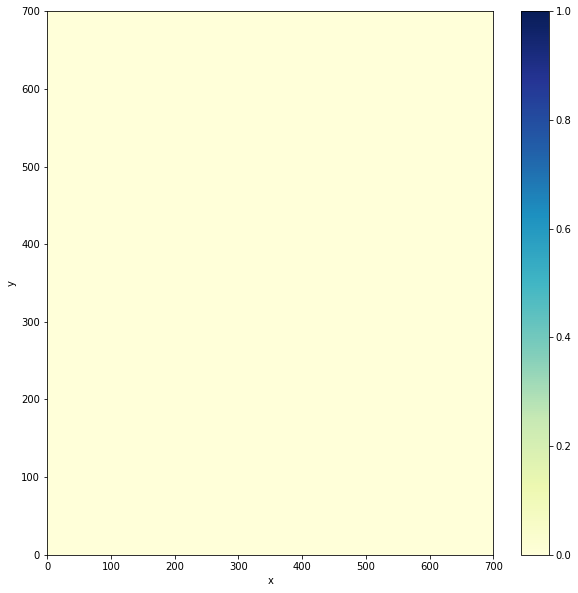

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_1.h5", 'x')
c_scan_1 = c_scan 
qx, qy, qt = c_scan.shape



x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))
y_1 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

x: (0.0, 0.7)
y: (1.0, 1.7)


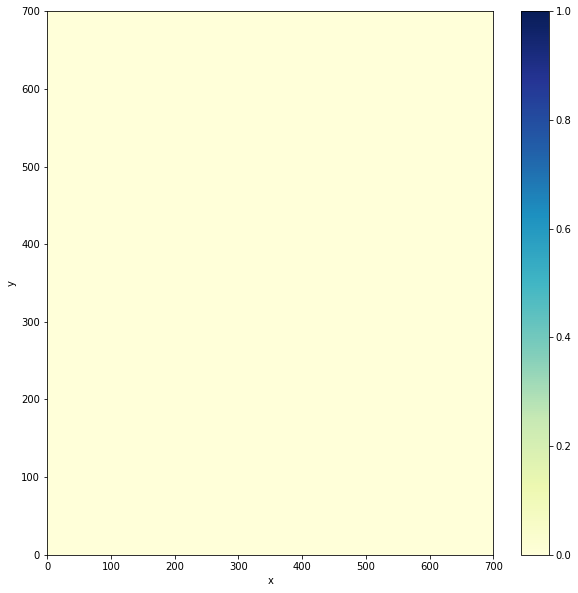

In [ ]:
c_scan = read_c_scan("C_scan_default_title_1.h5", 'x')
c_scan_1_g = c_scan 
qx, qy, qt = c_scan.shape

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))
y_1_g = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 2

x: (0.0, 0.7)
y: (0.0, 0.7)


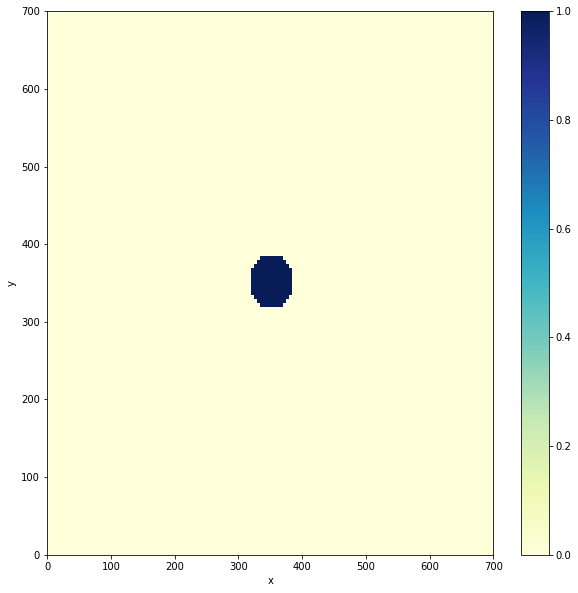

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_2.h5", 'x')
c_scan_2 = c_scan

qx, qy, qt = c_scan.shape
X_2 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_2 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)


x: (0.0, 0.7)
y: (0.0, 0.7)


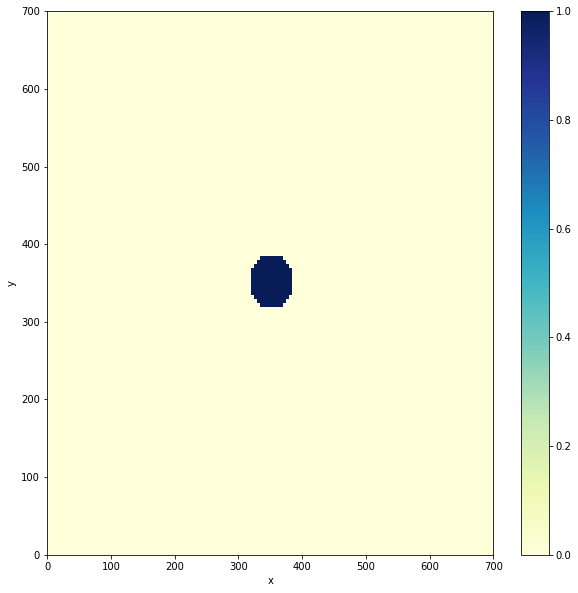

In [ ]:
c_scan = read_c_scan("C_scan_default_title_2.h5", 'x')
c_scan_2_g = c_scan

qx, qy, qt = c_scan.shape
X_2_g = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_2_g = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 3

x: (0.0, 0.7)
y: (0.0, 0.7)


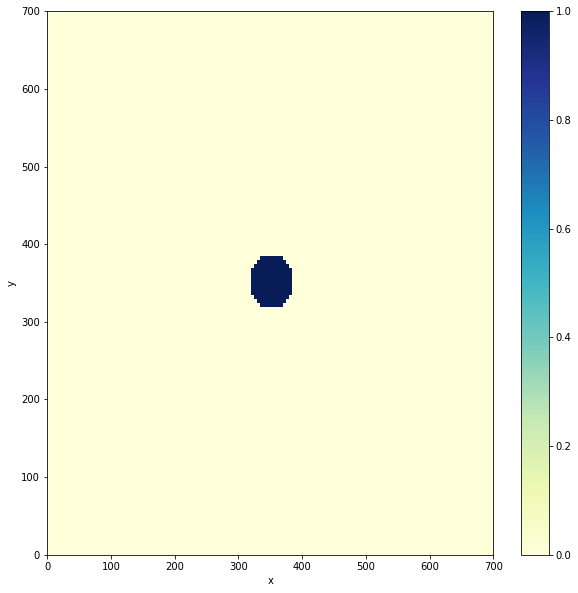

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_3.h5", "x")
c_scan_3 = c_scan
qx, qy, qt = c_scan.shape
X_3 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:, np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_3 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

x: (0.0, 0.7)
y: (0.0, 0.7)


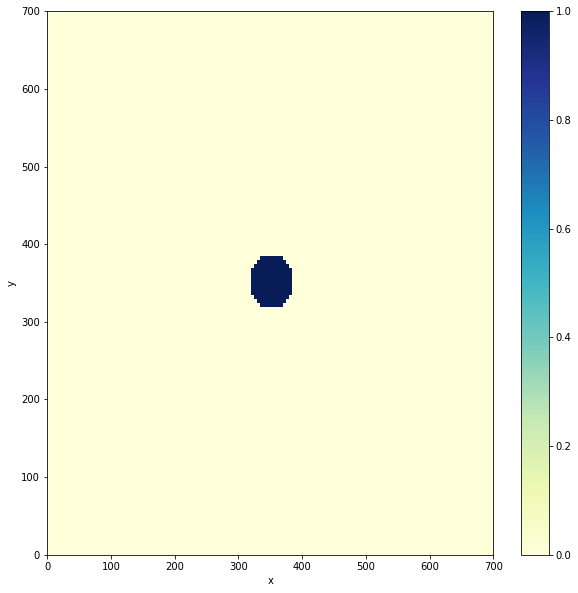

In [ ]:
c_scan = read_c_scan("C_scan_default_title_3.h5", "x")
c_scan_3_g = c_scan
qx, qy, qt = c_scan.shape
X_3_g = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:, np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_3_g = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 4

x: (0.0, 0.7)
y: (1.0, 1.7)


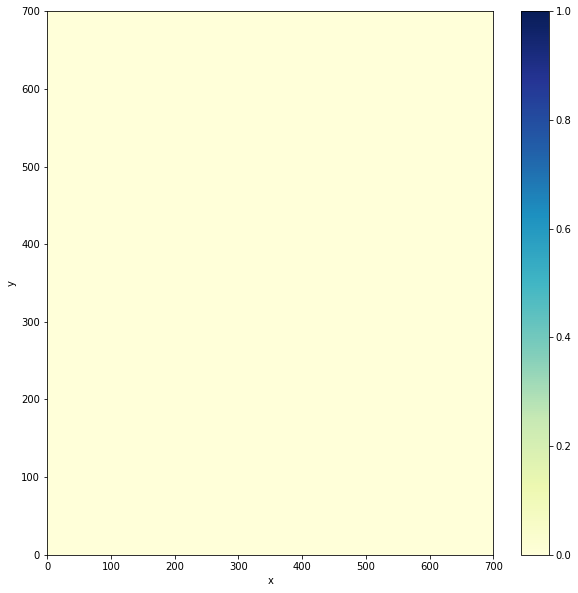

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_4.h5", 'x')
c_scan_4 = c_scan
qx, qy, qt = c_scan.shape
X_4 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

y_4 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 5

x: (0.0, 0.7)
y: (0.0, 0.7)


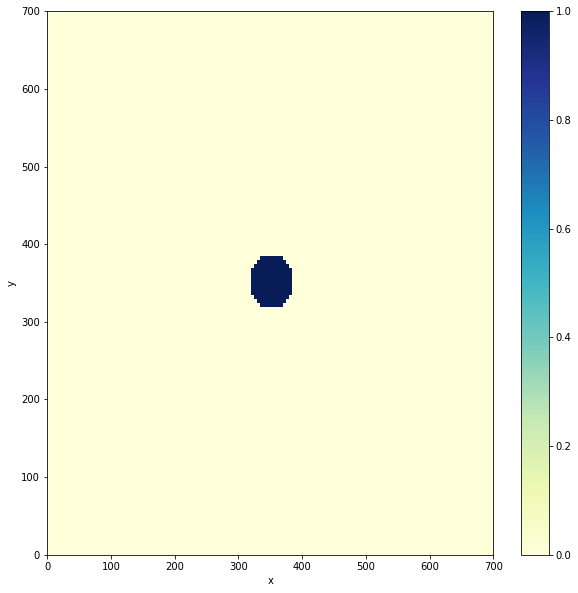

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_5.h5", 'x')
c_scan_5 = c_scan
qx, qy, qt = c_scan.shape
X_5 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_5 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 6

x: (0.0, 0.7)
y: (1.0, 1.7)


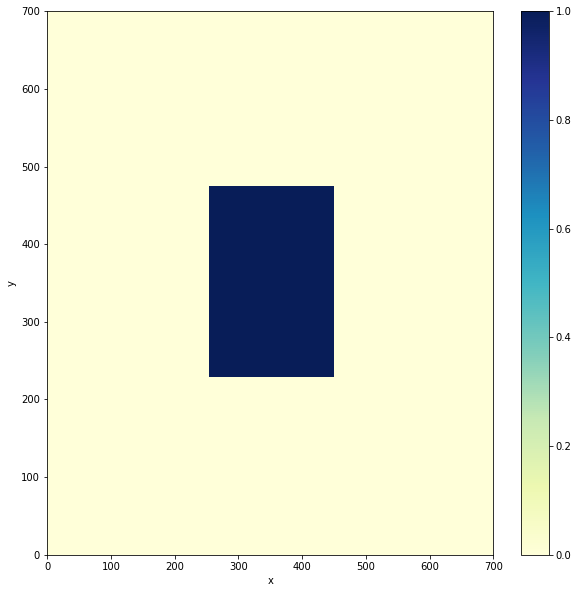

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_6.h5", 'x')
c_scan_6 = c_scan
qx, qy, qt = c_scan.shape
X_6 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
l = 250

mask_x= np.abs(x-cx) < 200/2.
mask_y= np.abs(y-cy) < 250/2

mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_6 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 7

x: (0.0, 0.7)
y: (0.0, 0.7)


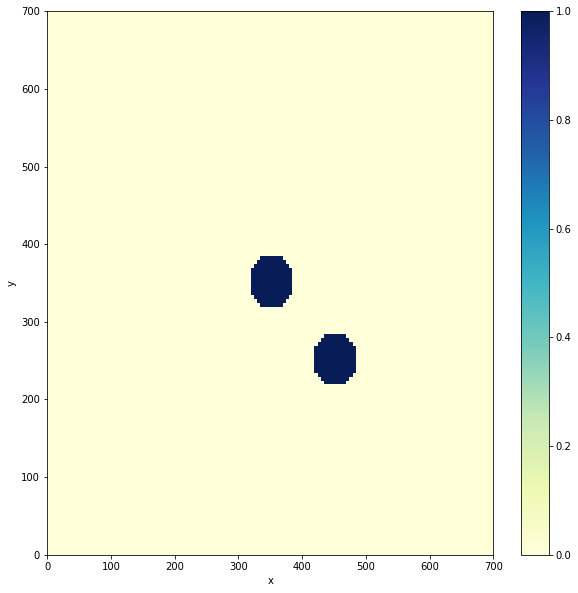

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_7.h5", 'x')
c_scan_7 = c_scan
qx, qy, qt = c_scan.shape
X_7 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx, cy, r = 350, 350, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 450, 250, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_7 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 8

x: (0.0, 0.7)
y: (1.0, 1.7)


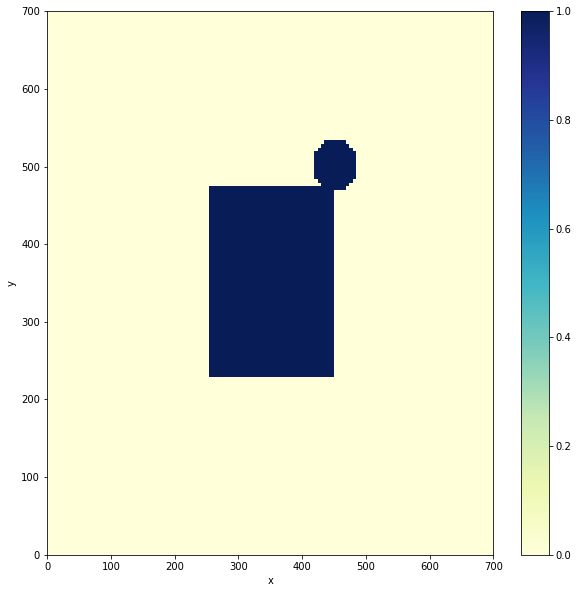

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_8.h5" ,"x")
c_scan_8 = c_scan
qx, qy, qt = c_scan.shape
X_8 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)
mine_map = np.zeros((x.size, y.size))

cx, cy, r = 450, 500, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, l = 350, 350, 250
mask_x= np.abs(x-cx) < 200/2
mask_y= np.abs(y-cy) < 250/2

mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_8 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 10

x: (0.0, 0.7)
y: (0.0, 0.7)


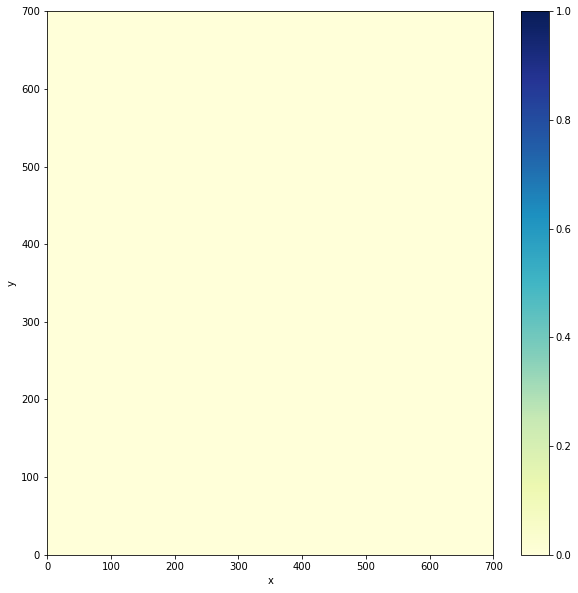

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_10.h5", 'x')
c_scan_10 = c_scan
qx, qy, qt = c_scan.shape
X_10 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

y_10 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 11

x: (0.0, 0.7)
y: (0.0, 0.7)


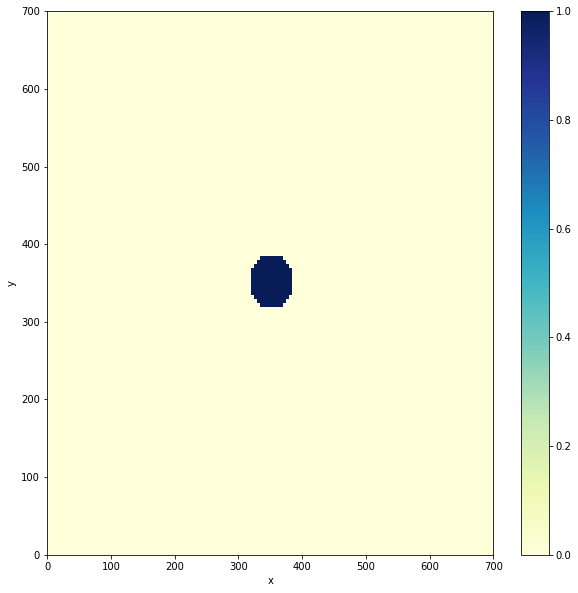

In [ ]:
c_scan = read_c_scan("C_Scan_time_raw_11.h5", 'x')
c_scan_11 = c_scan
qx, qy, qt = c_scan.shape
X_11 = np.reshape(c_scan, (qx * qy, qt))

x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((x.size, y.size))

cx = 350
cy = 350
r = 35

mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis, :]-cy)**2 < r**2
mine_map[mask] = 1

y_11 = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

## Escenario Nuevos

### Escenario - Solo arena

x: (0.0, 0.7)
y: (0.7, 1.4)


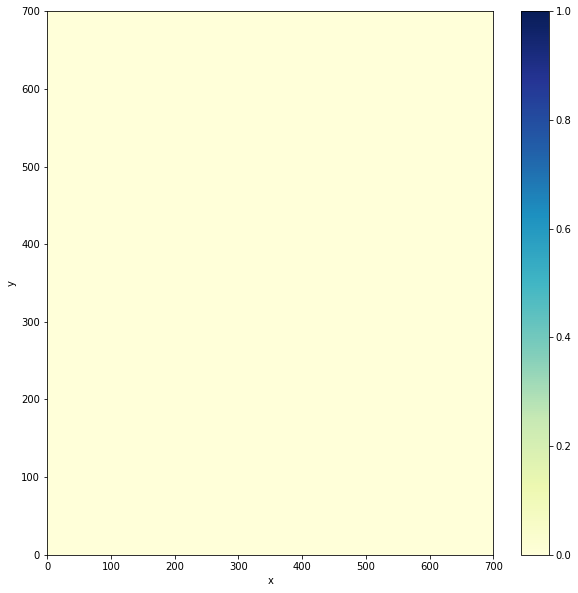

In [ ]:
c_scan = read_c_scan("C_scan_default_title_0_new.h5", 'x')
c_scan_0_new = c_scan 
qx, qy, qt = c_scan.shape
X_0_new = np.reshape(c_scan, (qx * qy, qt))


x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))
y_0_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 1

x: (0.0, 0.7)
y: (0.7, 1.4)


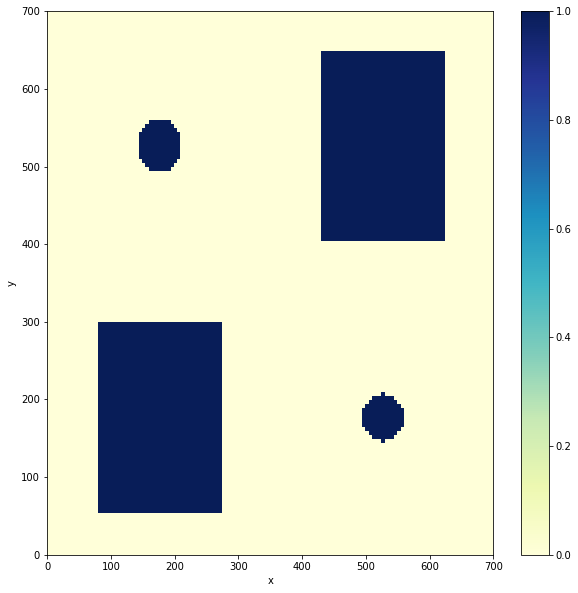

In [ ]:
c_scan = read_c_scan("C_scan_default_title_1_new.h5", 'x')
c_scan_1_new = c_scan 
qx, qy, qt = c_scan.shape
X_1_new = np.reshape(c_scan, (qx * qy, qt))


x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))

cx, cy, r = 175, 525, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, a, b = 525, 175, 66.3/2, 60.20/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, lx, ly = 175, 175, 200, 250
mask_x= np.abs(x-cx) < lx/2
mask_y= np.abs(y-cy) < ly/2
mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

cx, cy, lx, ly = 525, 525, 200, 250
mask_x= np.abs(x-cx) < lx/2
mask_y= np.abs(y-cy) < ly/2
mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_1_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

### Escenario 2

x: (0.0, 0.7)
y: (0.7, 1.4)


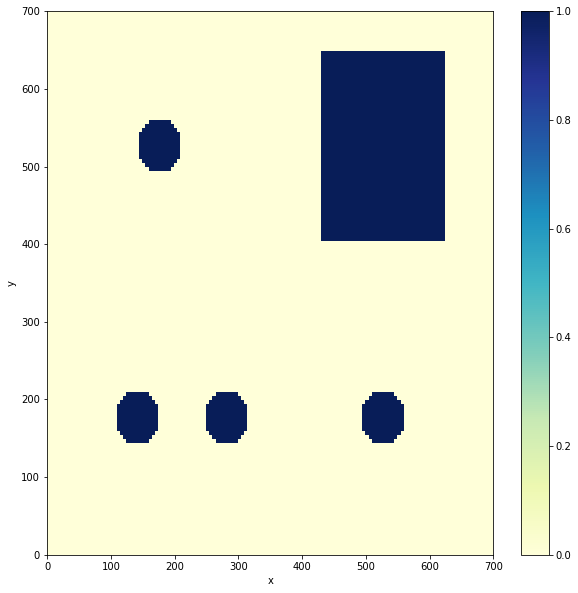

In [ ]:
c_scan = read_c_scan("C_scan_default_title_2_new.h5", 'x')
c_scan_2_new = c_scan 
qx, qy, qt = c_scan.shape
X_2_new = np.reshape(c_scan, (qx * qy, qt))


x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

mine_map = np.zeros((qx, qy))

cx, cy, r = 175, 525, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 525, 175, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 140, 175, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 140*2, 175, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, lx, ly = 525, 525, 200, 250
mask_x= np.abs(x-cx) < lx/2
mask_y= np.abs(y-cy) < ly/2
mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_2_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

###Escenario 3

x: (0.0, 0.7)
y: (0.7, 1.4)


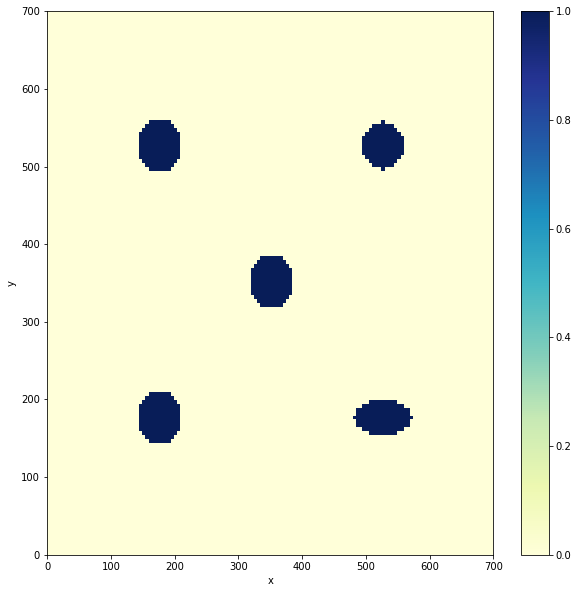

Number of A-scans with object: 687
Number of A-scans without object: 19194


In [ ]:
c_scan = read_c_scan("C_scan_default_title_3_new.h5", 'x')
c_scan_3_new = c_scan 
qx, qy, qt = c_scan.shape
X_3_new = np.reshape(c_scan, (qx * qy, qt))

mine_map = np.zeros((x.size, y.size))

cx, cy, r = 175, 525, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, a, b = 525, 525, 66.3/2, 60.20/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, r = 175, 175, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, a, b = 525, 175, 90.2/2, 46.45/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, r = 350, 350, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

y_3_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)
print(f"Number of A-scans with object: {len(mine_map[mine_map == 1])}")
print(f"Number of A-scans without object: {len(mine_map[mine_map == 0])}")

###Escenario 4

x: (0.0, 0.7)
y: (0.7, 1.4)


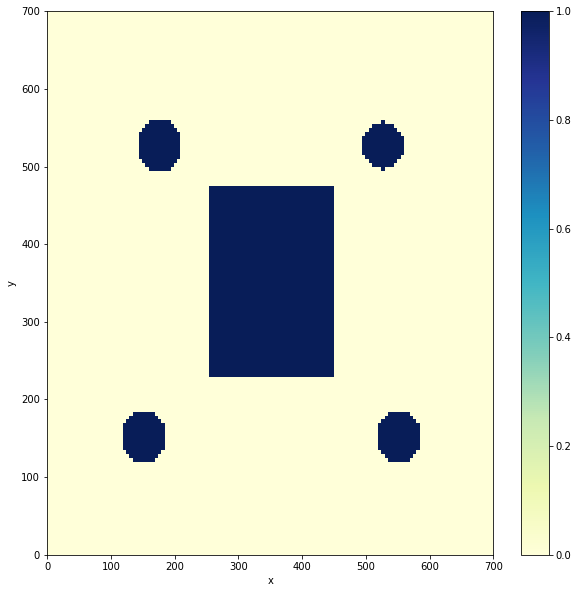

In [ ]:
c_scan = read_c_scan("C_scan_default_title_4_new.h5", 'x')
c_scan_4_new = c_scan 
qx, qy, qt = c_scan.shape
X_4_new = np.reshape(c_scan, (qx * qy, qt))

mine_map = np.zeros((x.size, y.size))

cx, cy, a, b = 525, 525, 66.3/2, 60.20/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, r = 175, 525, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 550, 150, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 150, 150, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, l = 350, 350, 250
mask_x= np.abs(x-cx) < 200/2
mask_y= np.abs(y-cy) < l/2
mine_map[np.ix_(np.flatnonzero(mask_x), np.flatnonzero(mask_y))] = 1

y_4_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map) 

### Esceanario 5

x: (0.0, 0.7)
y: (0.7, 1.4)


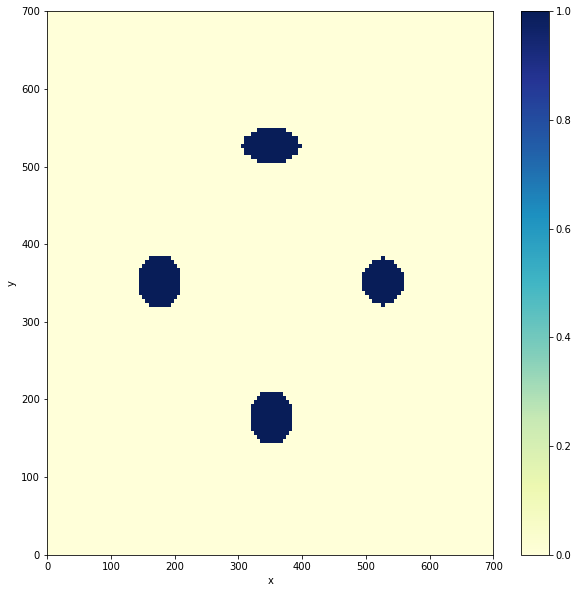

In [ ]:
c_scan = read_c_scan("C_scan_default_title_5_new.h5", 'x')
c_scan_5_new = c_scan 
qx, qy, qt = c_scan.shape
X_5_new = np.reshape(c_scan, (qx * qy, qt))

mine_map = np.zeros((x.size, y.size))

cx, cy, a, b = 350, 525, 90.2/2, 46.45/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, a, b = 525, 350, 66.3/2, 60.20/2
mask = (x[:,np.newaxis]-cx)**2/a**2 + (y[np.newaxis,:]-cy)**2/b**2 < 1
mine_map[mask] = 1

cx, cy, r = 350, 175, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

cx, cy, r = 175, 350, 35
mask = (x[:,np.newaxis]-cx)**2 + (y[np.newaxis,:]-cy)**2 < r**2
mine_map[mask] = 1

y_5_new = np.reshape(mine_map, (qx * qy))

plot_mine_map(x, y, mine_map)

## Entrenamiento

### Unión de Escenarios

In [ ]:
#X_train = np.concatenate((X_11, X_3_new), axis = 0)
#X_train = X_3_new
y_train = np.concatenate((y_1_new, y_2_new, y_3_new), axis = 0)
#y_train = y_3_new
print(f"Número de muestras sin objeto: {y_train[y_train == 0].shape[0]}")
print(f"Número de muestras con objeto: {y_train[y_train == 1].shape[0]}")

Número de muestras sin objeto: 52377
Número de muestras con objeto: 7266


In [ ]:
train_scenes = [
  (c_scan_1_new, y_1_new),
  (c_scan_2_new, y_2_new),
  (c_scan_3_new, y_3_new),
]

train_generator = DataGenerator(train_scenes, 
                                empty_scene = c_scan_0_new, 
                                removal = "average", 
                                scale = False)

In [ ]:
val_scenes = [
  (c_scan_2, y_3),
  (c_scan_5, y_5),
  (c_scan_8, y_8),
]

val_generator = DataGenerator(train_scenes, 
                              empty_scene = c_scan_0_new, 
                              removal = "average", 
                              scale = False)

### CNN





In [ ]:
n_a_scans = 141
n_time_steps = 141
n_channels = 2

input_shape = (n_a_scans, n_time_steps, n_channels)

model = tf.keras.Sequential([
  layers.Input(shape = input_shape),
  layers.Conv2D(filters = 32, kernel_size = (5, 5), strides = 1, activation = 'relu'),
  layers.MaxPooling2D(pool_size = (2, 2)),
  layers.BatchNormalization(),
  layers.Flatten(),
  layers.Dense(128, activation = 'relu'),
  layers.Dropout(0.75),
  layers.Dense(1, activation = 'sigmoid')
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam', 
    metrics=[tf.metrics.BinaryAccuracy(), 
             tfa.metrics.F1Score(num_classes = 1, average = 'macro', threshold = 0.5)]
    )

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 137, 137, 32)      1632      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 68, 68, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_1 (Batc  (None, 68, 68, 32)       128       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 147968)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               18940032  
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
class_weight = compute_class_weight(class_weight = 'balanced', classes = [0, 1], y = y_train)
class_weight

array([0.56936251, 4.10425268])

In [ ]:
early_stopping = callbacks.EarlyStopping(
    monitor = 'f1_score',
    patience = 10, 
    mode = 'max',
    restore_best_weights = True)

history = model.fit(train_generator,
                    epochs = 25,
                    #validation_data = val_generator,
                    callbacks = [early_stopping], 
                    class_weight = {0:class_weight[0], 1: class_weight[1]},
                    shuffle = True,
                    verbose = 1
                    )

Epoch 1/25
423/423 [==============================] - 31s 71ms/step - loss: 0.5072 - binary_accuracy: 0.8121 - f1_score: 0.4618
Epoch 2/25
423/423 [==============================] - 28s 66ms/step - loss: 0.3105 - binary_accuracy: 0.8817 - f1_score: 0.6307
Epoch 3/25
423/423 [==============================] - 28s 65ms/step - loss: 0.2388 - binary_accuracy: 0.8933 - f1_score: 0.6709
Epoch 4/25
423/423 [==============================] - 28s 66ms/step - loss: 0.2026 - binary_accuracy: 0.8997 - f1_score: 0.6930
Epoch 5/25
423/423 [==============================] - 28s 65ms/step - loss: 0.1783 - binary_accuracy: 0.9096 - f1_score: 0.7171
Epoch 6/25
423/423 [==============================] - 28s 65ms/step - loss: 0.2042 - binary_accuracy: 0.8941 - f1_score: 0.6841
Epoch 7/25
423/423 [==============================] - 28s 66ms/step - loss: 0.1622 - binary_accuracy: 0.9120 - f1_score: 0.7251
Epoch 8/25
423/423 [==============================] - 28s 65ms/step - loss: 0.1568 - binary_accuracy: 0.

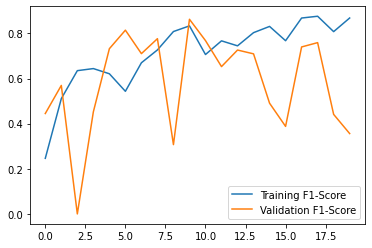

In [ ]:
plt.plot(history.history["f1_score"], label="Training F1-Score")
plt.plot(history.history["val_f1_score"], label="Validation F1-Score")
plt.legend()

In [ ]:
model.save('cnn-2channels-1conv-sub2.h5')

## Evaluación

In [ ]:
removal_strategy  = "average"
window_size = 10
c_scan_base = c_scan_1
qx, qy = 141, 141
x = np.linspace(0, 700, qx)
y = np.linspace(0, 700, qy)

### Escenario 1

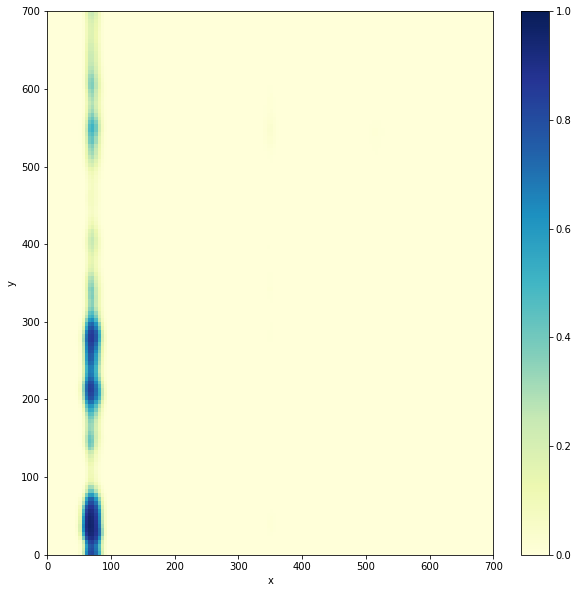

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_1, y_1)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy,
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 2

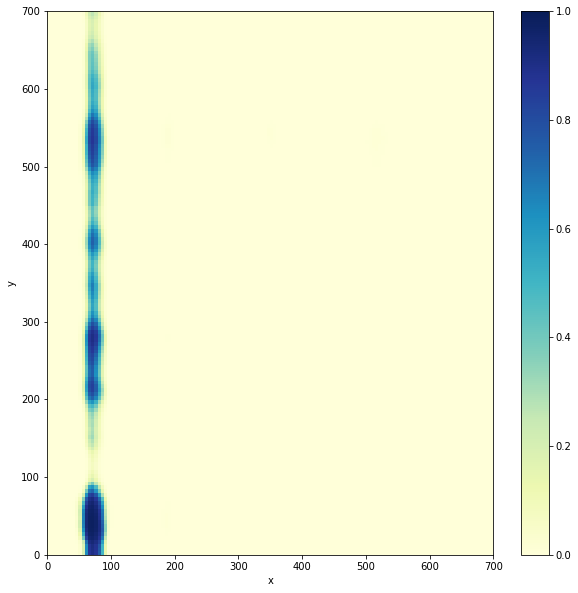

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_2, y_2)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 3

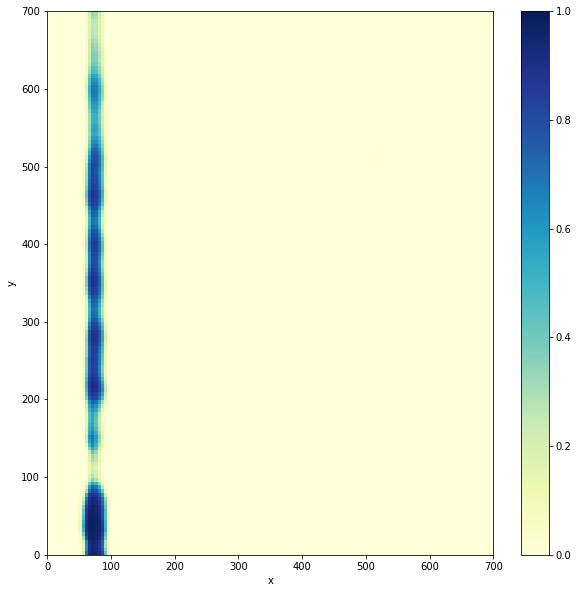

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_3, y_3)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 4

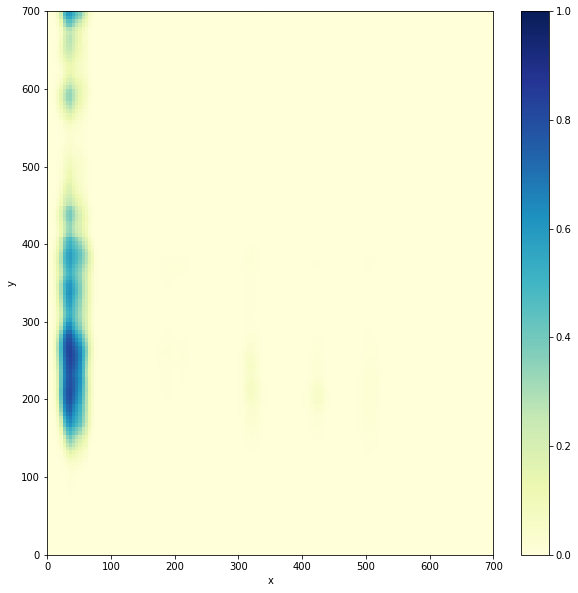

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_4, y_4)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 5

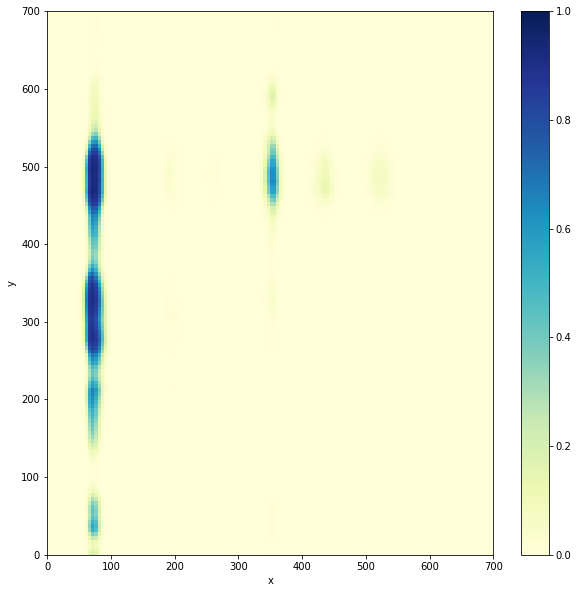

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_5, y_5)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 6

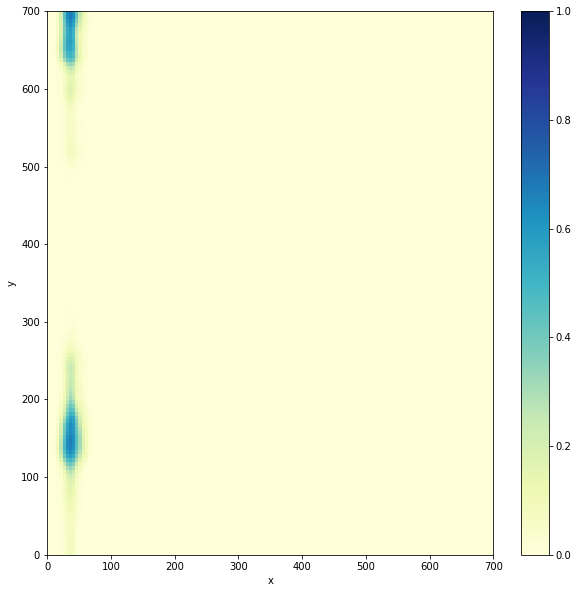

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_6, y_6)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 7

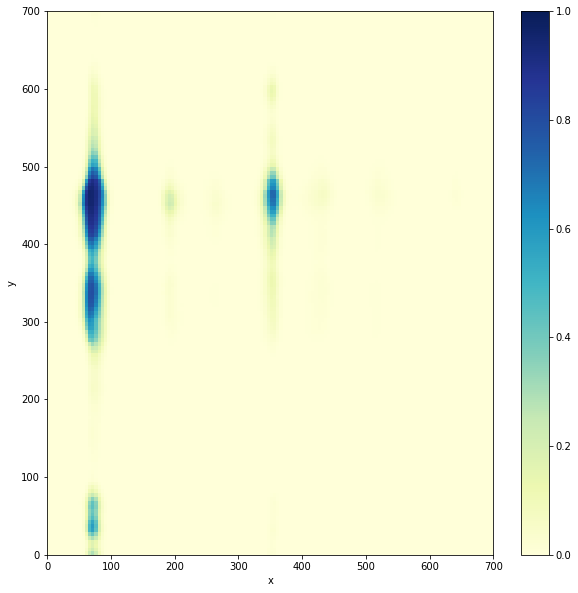

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_7, y_7)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 8

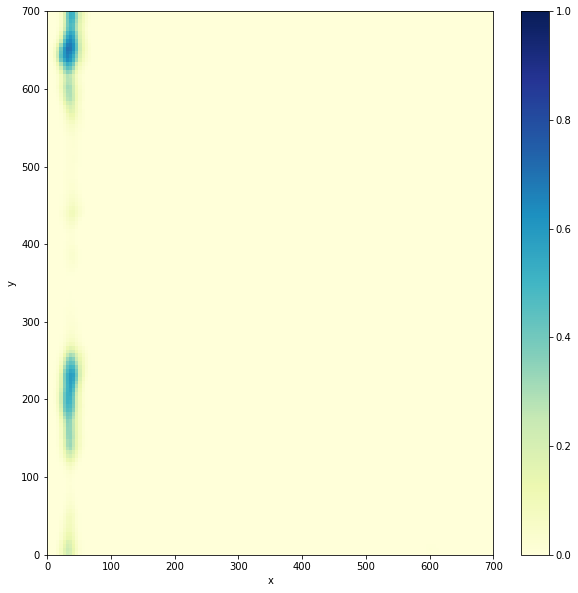

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_8, y_8)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 10

In [ ]:
c_scan_base = c_scan_10

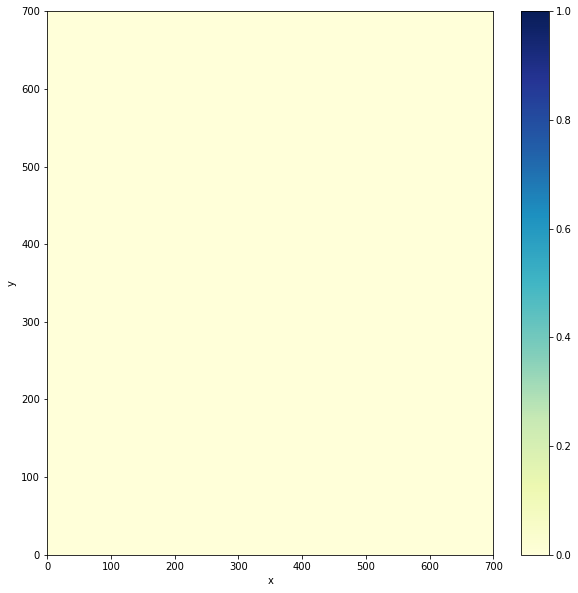

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_10, y_10)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 11

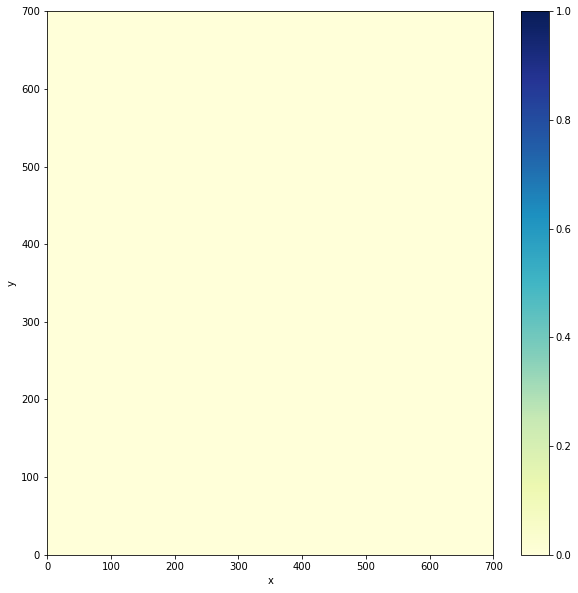

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_11, y_11)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenarios Gabriel

In [ ]:
c_scan_base = c_scan_1_g

### Escenario 1



In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_1_g, y_1_g)]))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

NameError: ignored

### Escenario 2

Min: -0.010139654390513897, Max: 0.009298478369601071


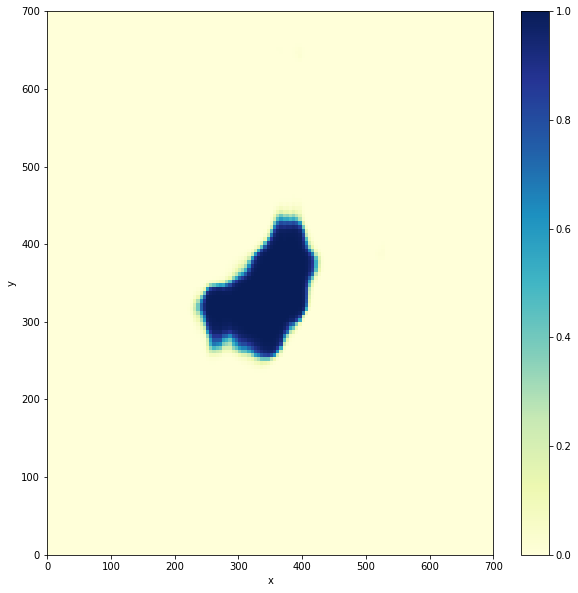

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_2_g - c_scan_base, y_2_g)], remove_average = remove_average))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

### Escenario 3

Min: -0.009947070851922035, Max: 0.009120070142671466


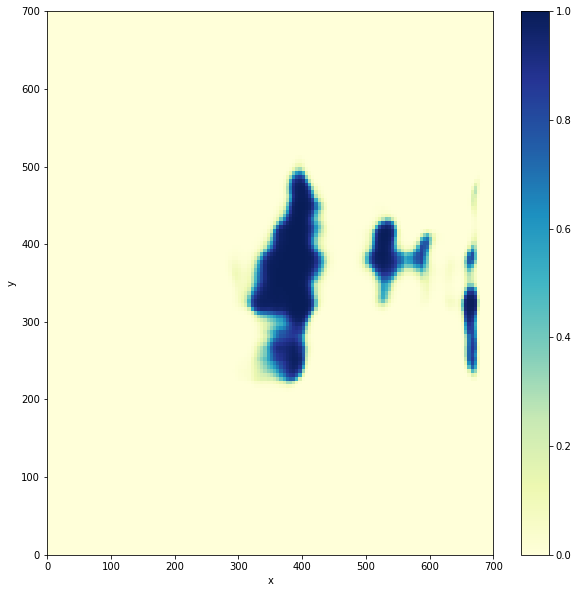

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_3_g - c_scan_base, y_3_g)], remove_average = remove_average))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

## Escenarios Nuevos

In [ ]:
removal_strategy  = "average"
window_size = 10
scale = False
c_scan_base = c_scan_0_new

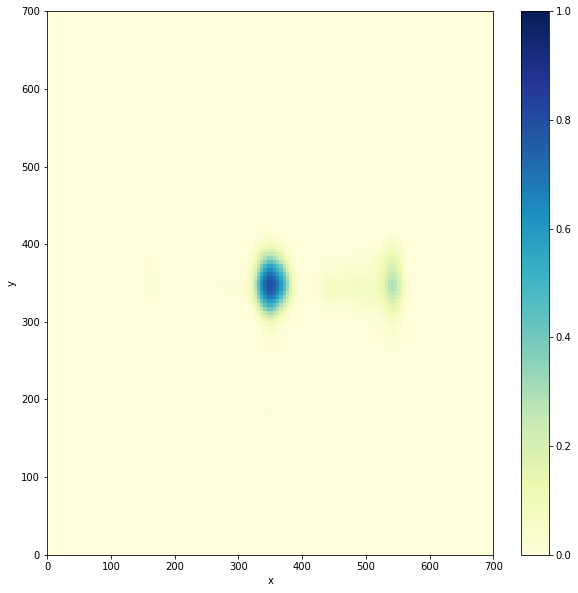

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_0_new, y_0_new)],
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

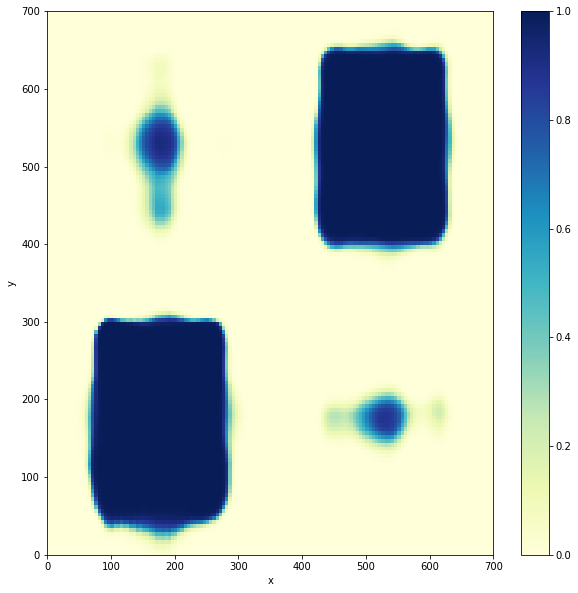

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_1_new, y_1_new)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

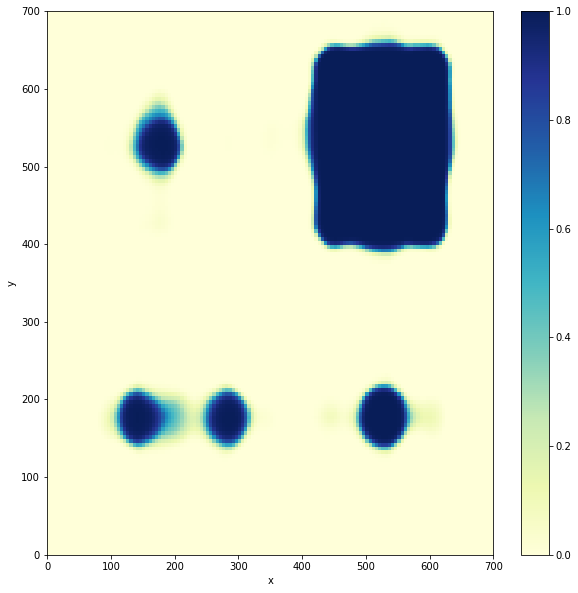

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_2_new, y_2_new)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

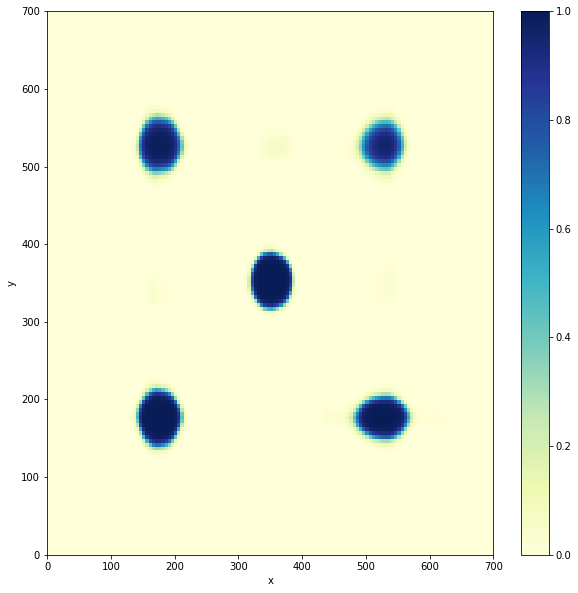

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_3_new, y_3_new)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

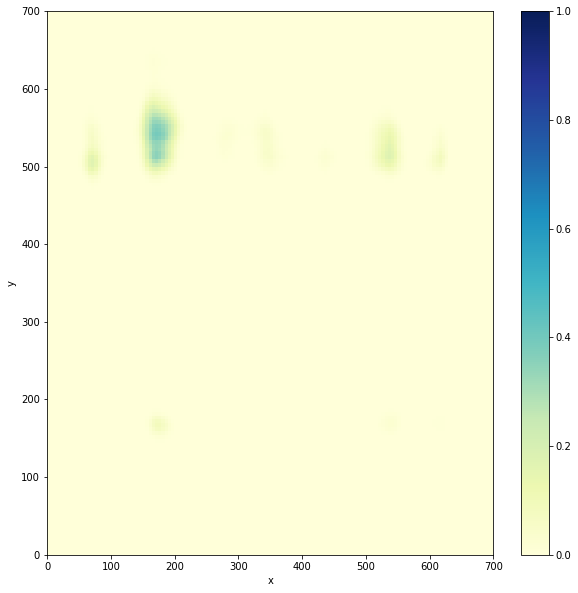

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_4_new, y_4_new)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)

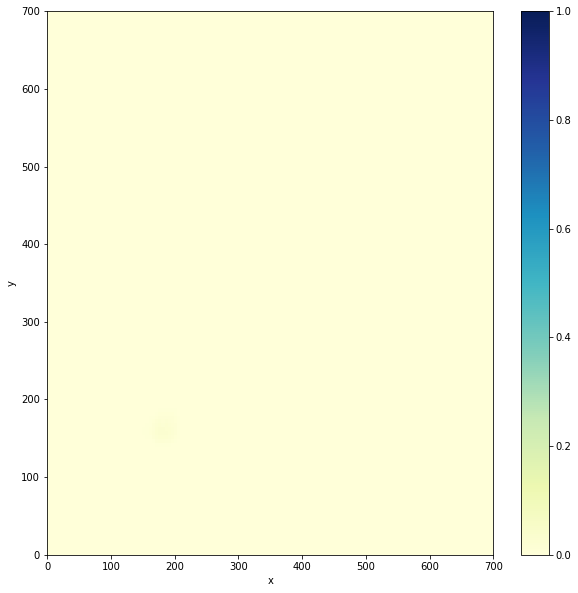

In [ ]:
mine_pred = model.predict(DataGenerator([(c_scan_5_new, y_5_new)], 
                                        empty_scene = c_scan_base, 
                                        removal = removal_strategy, 
                                        window_size = window_size, 
                                        scale = scale))
mine_pred = np.reshape(mine_pred, (qx, qy))
plot_mine_map(x, y, mine_pred)